In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet201, VGG16, VGG19, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.2.1
Numpy: 1.22.1
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 250, 200
num_classes = 3

data_dir = "./Dataset 2"
class_names = os.listdir(data_dir)

# test set
source_data_dir = "./Dataset 2"
test_data_dir = "./Testset 2"
valid_data_dir = "./Validset 2"
class_names = os.listdir(source_data_dir)

first_execution = True

if first_execution:
    create_test_set(source_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(source_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.00,
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
)

data_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    classes = class_names
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        "./Validset 2",
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'categorical',
        shuffle = True,
        classes = class_names
)

Found 662 images belonging to 3 classes.
Found 165 images belonging to 3 classes.


In [6]:
base_model = ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

# freeze already trained layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu', kernel_initializer = 'uniform')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 63, 50, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 63, 50, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 63, 50, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 63, 50, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 25, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 25, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 25, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 25, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 13, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 13, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 13, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator, verbose = 0)

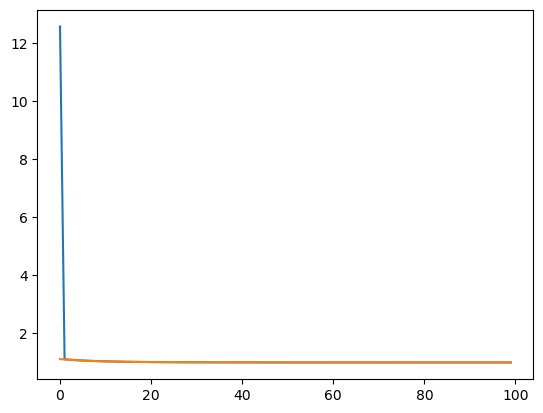

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

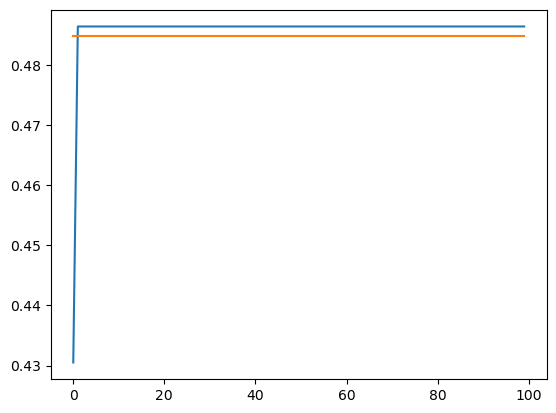

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    batch_size = count_files_in_directory(test_data_dir),
    shuffle = False,
    classes = class_names
)

Found 352 images belonging to 3 classes.


In [12]:
real_labels = []
test_probs = []
test_labels = []
test_errors = []
batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    test_prob = model.predict(np.expand_dims(single_image_array, axis=0), verbose = 0)
    test_pred = np.argmax(test_prob)
    test_error = np.sqrt(np.mean((test_prob - single_image_label) ** 2))
    
    
    real_labels.append(single_image_label)
    test_probs.append(test_prob[0, test_pred])
    test_labels.append(test_pred)
    test_errors.append(test_error)

test_probs = np.array(test_probs).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)
test_errors = np.array(test_errors).reshape(-1)

In [13]:
class_labels = []
for array in real_labels:
    class_label = np.argmax(array)
    class_labels.append(class_label)
real_labels = class_labels
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]
indices2 = [index for index, value in enumerate(real_labels) if value == 2]

In [14]:
print(f"Test Tooth Score Loss {np.mean(test_errors[indices1]) * 100:.2f}%")
print(f"Test Cut Mark Loss {np.mean(test_errors[indices0]) * 100:.2f}%")
print(f"Test Trampling Mark Loss {np.mean(test_errors[indices2]) * 100:.2f}%")
print(f"Overall Loss {np.mean(test_errors) * 100:.2f}%")

Test Tooth Score Loss 45.82%
Test Cut Mark Loss 37.87%
Test Trampling Mark Loss 61.70%
Overall Loss 43.99%


In [15]:
print(classification_report(real_labels, test_labels))
print(confusion_matrix(real_labels, test_labels))

              precision    recall  f1-score   support

           0       0.49      1.00      0.65       171
           1       0.00      0.00      0.00       136
           2       0.00      0.00      0.00        45

    accuracy                           0.49       352
   macro avg       0.16      0.33      0.22       352
weighted avg       0.24      0.49      0.32       352

[[171   0   0]
 [136   0   0]
 [ 45   0   0]]


C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [16]:
return_files = True

if return_files:
    source_folders = ["Testset 2", "Validset 2"]
    destination_folder = "Dataset 2"

    for source_folder in source_folders:
        source_path = os.path.join(source_folder, "Cut-marks")
        destination_path = os.path.join(destination_folder, "Cut-marks")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Scores")
        destination_path = os.path.join(destination_folder, "Scores")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Tramplings")
        destination_path = os.path.join(destination_folder, "Tramplings")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

    print("Files moved successfully.")

Files moved successfully.


In [17]:
import winsound
winsound.Beep(1000, 2000)  # Beep at 1000 Hz for 200 milliseconds